In [1]:
from greedy_mcmc_attack import *
from data_collection.recordings import *
import sys
sys.path.append("../../")
from src.models.gcn import *
from src.models.gat import *
from src.models.gsage import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# dataset_directory = "../Cora"
cora_dataset = Planetoid(root='', name='Cora')
data = cora_dataset[0].to(device)
print(data)

trials = 5

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [4]:
edges_to_add = None

In [5]:
model = GCN(data.x.shape[1], cora_dataset.num_classes, [16]).to(device)

In [6]:
model_save_path = "../models/cora_gcn_model.pth"
list_save_path = "../attacks/cora_gcn_edges_full_run.pth"
# # multi_metattack_edges_list.pth
# list_save_path = "multi_metattack_edges_list.pth"

In [7]:
model, edges_to_add, train = load_model_and_edges(model_save_path, list_save_path, model, device)

In [8]:
# Get initial accuracy
initial_loss, initial_accuracy = train.test(data)
print(f"Initial Accuracy: {initial_accuracy}")
print(f"Initial Loss: {initial_loss}")

Initial Accuracy: 0.759
Initial Loss: 1.9119181632995605


In [9]:
G, initial_edge_count, ptb_rate, budget = initialize(data, _ptb_rate=0.20)

In [10]:
full_metattack_acc, full_metattack_loss, full_metattack_itrs = [], [], []
for _ in range(trials):
    acc, loss, itrs = two_phase_attack_mcmc(data, train, model, 0.0, edges_to_add, binary_fn, constant_fn, device, is_reversed=False, verbose=True)
    full_metattack_acc.append(acc)
    full_metattack_loss.append(loss)
    full_metattack_itrs.append(itrs)

Peturbing graph...:   0%|          | 0/527 [00:00<?, ?it/s]

Peturbing graph...:   0%|          | 0/527 [00:00<?, ?it/s]

In [11]:
# splits = [0.0, 0.5, 0.7, 0.9]
# # splits = [0.9]
# # split_dic_acc = defaultdict(defaultdict(list))
# # split_dic_loss = defaultdict(defaultdict(list))
# # itrs_one = defaultdict(defaultdict(int))

In [12]:
# for s in splits:
#     if s == 0.0:
#         split_dic_acc[s], split_dic_loss[s], itrs_one[s] = full_metattack_acc[j], full_metattack_loss[j], full_metattack_itrs[j]
#     else:
#         split_dic_acc[s], split_dic_loss[s], itrs_one[s] = two_phase_attack_mcmc(data, train, model, s, edges_to_add, binary_fn, constant_fn, device, is_reversed=True, verbose=True)

In [13]:
# record1 = Recording(split_dic_loss, split_dic_acc, itrs_one, Model.GCN, Dataset.CORA, AcceptFn.CONSTANT, SelectFn.BINARY, Reverse.REVERSED)
# record1.save(f'data_collection/{"mcmc"}_{"gcn"}_{"cora"}_{"constant"}_{"binary"}_{"reversed"}_results.pkl')

In [14]:
# plot_results(split_dic_acc, ptb_rate, "MCMC", "binary", "constant", "accuracy", "reversed")

In [15]:
# plot_results(split_dic_loss, ptb_rate, "MCMC", "binary", "constant", "loss", "reversed")

##### ideally, we could show some metric, where (change in loss after hidden for %) > (% * max change in loss)

In [16]:
# split_dic_decreasing_acc = defaultdict(defaultdict(list))
# itrs_two = defaultdict(defaultdict(int))
# split_dic_decreasing_loss = defaultdict(defaultdict(list))

In [17]:
# for s in splits:
#     if s == 0.0:
#         split_dic_decreasing_acc[s], split_dic_decreasing_loss[s], itrs_two[s] = full_metattack_acc[j], full_metattack_loss[j], full_metattack_itrs[j]
#     else:
#         split_dic_decreasing_acc[s], split_dic_decreasing_loss[s], itrs_two[s] = two_phase_attack_mcmc(data, train, model, s, edges_to_add, binary_fn, increasing_fn, device, is_reversed=True, verbose=True)

In [18]:
# record1 = Recording(split_dic_decreasing_loss, split_dic_decreasing_acc, itrs_two, Model.GCN, Dataset.CORA, AcceptFn.INCREASING, SelectFn.BINARY, Reverse.REVERSED)
# record1.save(f'data_collection/{"mcmc"}_{"gcn"}_{"cora"}_{"increasing"}_{"binary"}_{"reversed"}_results.pkl')

In [19]:
# plot_results(split_dic_decreasing_acc, ptb_rate, "MCMC", "binary", "increasing", "accuracy", "reversed")

In [20]:
# plot_results(split_dic_decreasing_loss, ptb_rate, "MCMC", "binary", "increasing", "loss", "reversed")

In [21]:
# split_dic_decreasing_constant_acc = defaultdict(defaultdict(list))
# split_dic_decreasing_constant_loss = defaultdict(defaultdict(list))
# itrs_three = defaultdict(defaultdict(int))

In [22]:
# for s in splits:
#     if s == 0.0:
#         split_dic_decreasing_constant_acc[s], split_dic_decreasing_constant_loss[s], itrs_three[s] = full_metattack_acc[j], full_metattack_loss[j], full_metattack_itrs[j]
#     else:
#         split_dic_decreasing_constant_acc[s], split_dic_decreasing_constant_loss[s], itrs_three[s] = two_phase_attack_mcmc(data, train, model, s, edges_to_add, decreasing_fn, constant_fn, device, is_reversed=True, verbose=True)

In [23]:
# record1 = Recording(split_dic_decreasing_constant_loss, split_dic_decreasing_constant_acc, itrs_three, Model.GCN, Dataset.CORA, AcceptFn.CONSTANT, SelectFn.DECAYING, Reverse.REVERSED)
# record1.save(f'data_collection/{"mcmc"}_{"gcn"}_{"cora"}_{"constant"}_{"decaying"}_{"reversed"}_results.pkl')

In [24]:
# plot_results(split_dic_decreasing_constant_acc, ptb_rate, "MCMC", "decaying", "constant", "accuracy", "reversed")

In [25]:
# plot_results(split_dic_decreasing_constant_loss, ptb_rate, "MCMC", "decaying", "constant", "loss", "reversed")

In [26]:
# split_dic_decreasing_gradual_acc = defaultdict(defaultdict(list))
# split_dic_decreasing_gradual_loss = defaultdict(defaultdict(list))
# itrs_four = defaultdict(defaultdict(int))

In [27]:
# for s in splits:
#     if s == 0.0:
#         split_dic_decreasing_gradual_acc[s], split_dic_decreasing_gradual_loss[s], itrs_four[s] = full_metattack_acc[j], full_metattack_loss[j], full_metattack_itrs[j]
#     else:
#         split_dic_decreasing_gradual_acc[s], split_dic_decreasing_gradual_loss[s], itrs_four[s] = two_phase_attack_mcmc(data, train, model, s, edges_to_add, decreasing_fn, increasing_fn, device, is_reversed=True, verbose=True)

In [28]:
# record1 = Recording(split_dic_decreasing_gradual_loss, split_dic_decreasing_gradual_acc, itrs_four, Model.GCN, Dataset.CORA, AcceptFn.CONSTANT, SelectFn.DECAYING, Reverse.REVERSED)
# record1.save(f'data_collection/{"mcmc"}_{"gcn"}_{"cora"}_{"increasing"}_{"decaying"}_{"reversed"}_results.pkl')

In [29]:
# plot_results(split_dic_decreasing_gradual_acc, ptb_rate, "MCMC", "decaying", "increasing", "accuracy", "reversed")

In [30]:
# plot_results(split_dic_decreasing_gradual_loss, ptb_rate, "MCMC", "decaying", "increasing", "accuracy", "reversed")

# regular, secondary attack, not reversed

In [31]:
splits = [0.0, 0.5]
# splits = [0.0, 0.5, 0.7, 0.9]
# splits = [0.9]
split_dic_acc = defaultdict(defaultdict(list))
split_dic_loss = defaultdict(defaultdict(list))
itrs_one = defaultdict(defaultdict(int))

In [32]:
for s in splits:
    for j in range(trials):
        if s == 0.0:
            split_dic_acc[s][j], split_dic_loss[s][j], itrs_one[s][j] = full_metattack_acc[j], full_metattack_loss[j], full_metattack_itrs[j]
        else:
            split_dic_acc[s][j], split_dic_loss[s][j], itrs_one[s][j] = two_phase_attack_mcmc(data, train, model, s, edges_to_add, binary_fn, constant_fn, device, is_reversed=False, verbose=True)

Peturbing graph...:   0%|          | 0/263 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
max_change: 0.0191191828250885, master_clean_delta: -0.0022450685501098633, master_dirty_delta: -0.002245306968688965
Attempt: 1, Selected: 0
max_change: 0.0191191828250885, master_clean_delta: 0.004853487014770508, master_dirty_delta: -0.0006378889083862305
Attempt: 2, Selected: 0
max_change: 0.0191191828250885, master_clean_delta: 0.0, master_dirty_delta: 0.0
Attempt: 16, Selected: 10
Attempt: 17, Selected: 10
max_change: 0.0191191828250885, master_clean_delta: -0.00024366378784179688, master_dirty_delta: 0.001958012580871582
Attempt: 36, Selected: 20
max_change: 0.0191191828250885, master_clean_delta: 0.004330754280090332, master_dirty_delta: 0.006572365760803223
Attempt: 37, Selected: 20
max_change: 0.0191191828250885, master_clean_delta: 0.005021452903747559, master_dirty_delta: 0.0067948102951049805
Attempt: 49, Selected: 30
max_change: 0.0191191828250885, master_clean_delta: 0.0094834566116333, master_dirty_delta: 0.010634064674377441
Attempt: 50, Selecte

Peturbing graph...:   0%|          | 0/272 [00:00<?, ?it/s]

In [33]:
record1 = Recording(split_dic_loss, split_dic_acc, itrs_one, Model.GCN, Dataset.CORA, AcceptFn.CONSTANT, SelectFn.BINARY, Reverse.ATTACKED)
record1.save(f'data_collection/{"mcmc"}_{"gcn"}_{"cora"}_{"constant"}_{"binary"}_{"attacked"}_results.pkl')

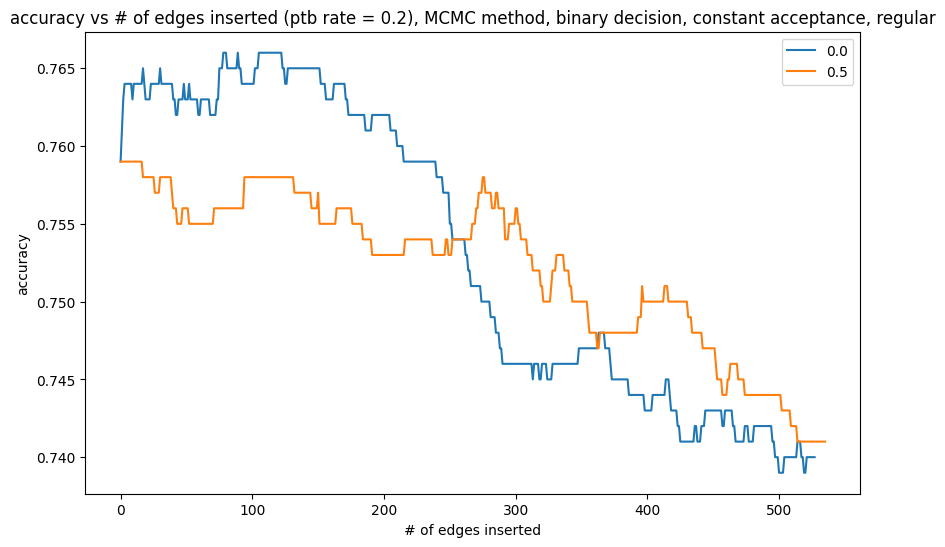

In [34]:
plot_results(split_dic_acc, ptb_rate, "MCMC", "binary", "constant", "accuracy", "regular")

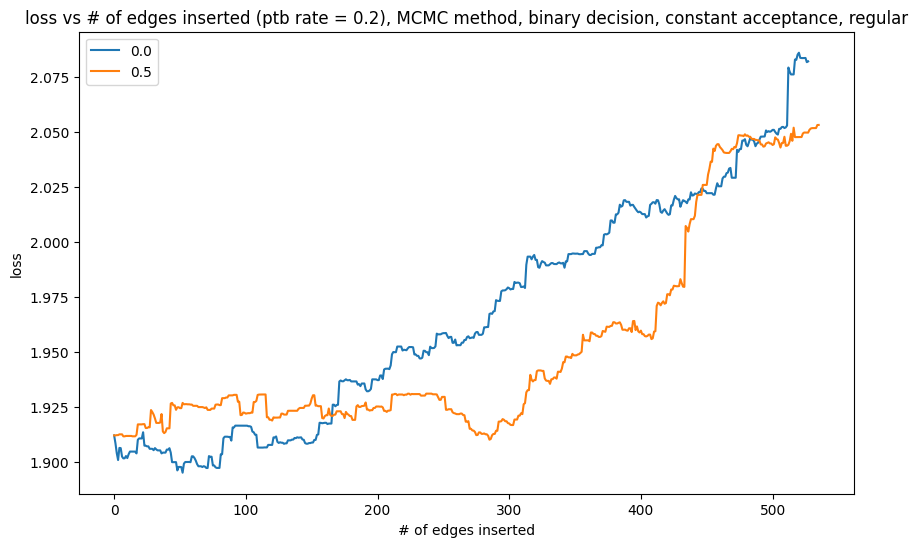

In [35]:
plot_results(split_dic_loss, ptb_rate, "MCMC", "binary", "constant", "loss", "regular")

##### ideally, we could show some metric, where (change in loss after hidden for %) > (% * max change in loss)

In [36]:
split_dic_decreasing_acc = defaultdict(defaultdict(list))
itrs_two = defaultdict(defaultdict(int))
split_dic_decreasing_loss = defaultdict(defaultdict(list))

In [37]:
for s in splits:
    for j in range(trials):
        if s == 0.0:
            split_dic_decreasing_acc[s][j], split_dic_decreasing_loss[s][j], itrs_two[s][j] = full_metattack_acc[j], full_metattack_loss[j], full_metattack_itrs[j]
        else:
            split_dic_decreasing_acc[s][j], split_dic_decreasing_loss[s][j], itrs_two[s][j] = two_phase_attack_mcmc(data, train, model, s, edges_to_add, binary_fn, increasing_fn, device, is_reversed=False, verbose=True)

Peturbing graph...:   0%|          | 0/263 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
max_change: 0.019119181632995606, master_clean_delta: -0.002245306968688965, master_dirty_delta: -0.002245306968688965
Attempt: 1, Selected: 0
max_change: 0.019119181632995606, master_clean_delta: 0.004853487014770508, master_dirty_delta: -0.0006378889083862305
Attempt: 2, Selected: 0
max_change: 0.019119181632995606, master_clean_delta: 1.1920928955078125e-07, master_dirty_delta: 0.0
Attempt: 3, Selected: 0
max_change: 0.019119181632995606, master_clean_delta: -2.384185791015625e-07, master_dirty_delta: -3.5762786865234375e-07
Attempt: 4, Selected: 0
max_change: 0.019119181632995606, master_clean_delta: 0.00013327598571777344, master_dirty_delta: 0.00013303756713867188
Attempt: 5, Selected: 0
max_change: 0.019119181632995606, master_clean_delta: 0.0, master_dirty_delta: 5.125999450683594e-06
Attempt: 31, Selected: 10
max_change: 0.019119181632995606, master_clean_delta: -0.00010156631469726562, master_dirty_delta: 0.003337860107421875
Attempt: 47, Selected: 20


Peturbing graph...:   0%|          | 0/272 [00:00<?, ?it/s]

In [38]:
record1 = Recording(split_dic_decreasing_loss, split_dic_decreasing_acc, itrs_two, Model.GCN, Dataset.CORA, AcceptFn.INCREASING, SelectFn.BINARY, Reverse.ATTACKED)
record1.save(f'data_collection/{"mcmc"}_{"gcn"}_{"cora"}_{"increasing"}_{"binary"}_{"attacked"}_results.pkl')

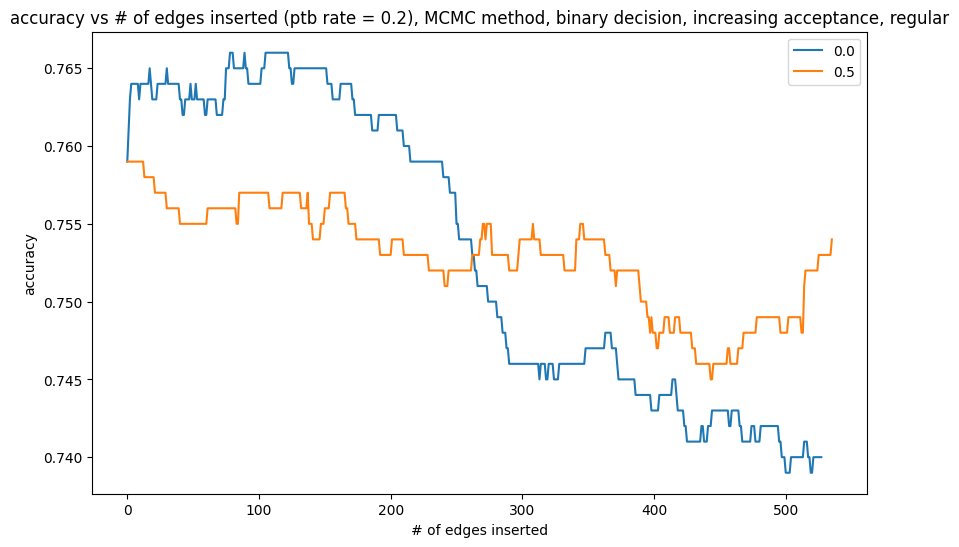

In [39]:
plot_results(split_dic_decreasing_acc, ptb_rate, "MCMC", "binary", "increasing", "accuracy", "regular")

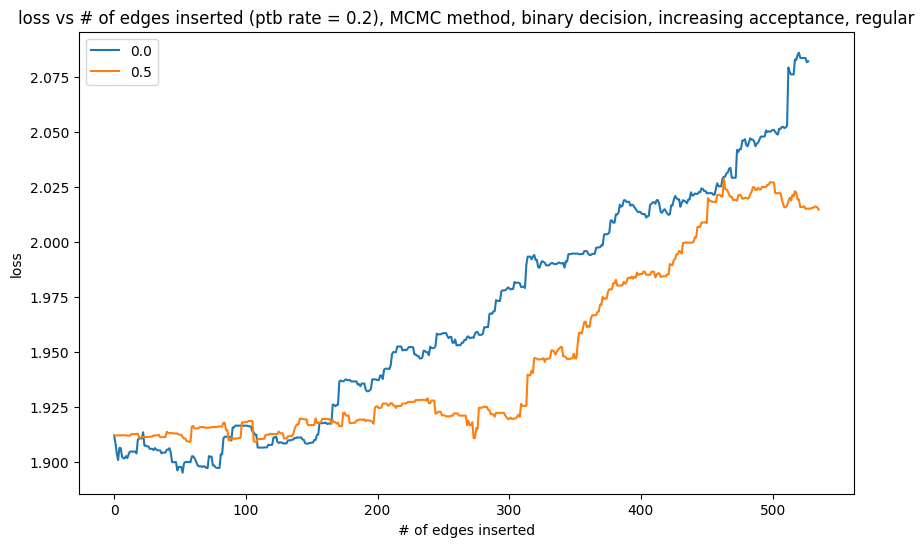

In [40]:
plot_results(split_dic_decreasing_loss, ptb_rate, "MCMC", "binary", "increasing", "loss", "regular")

In [41]:
split_dic_decreasing_constant_acc = defaultdict(defaultdict(list))
split_dic_decreasing_constant_loss = defaultdict(defaultdict(list))
itrs_three = defaultdict(defaultdict(int))

In [42]:
for s in splits:
    for j in range(trials):
        if s == 0.0:
            split_dic_decreasing_constant_acc[s][j], split_dic_decreasing_constant_loss[s][j], itrs_three[s][j] = full_metattack_acc[j], full_metattack_loss[j], full_metattack_itrs[j]
        else:
            split_dic_decreasing_constant_acc[s][j], split_dic_decreasing_constant_loss[s][j], itrs_three[s][j] = two_phase_attack_mcmc(data, train, model, s, edges_to_add, decreasing_fn, constant_fn, device, is_reversed=False, verbose=True)

Peturbing graph...:   0%|          | 0/263 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
max_change: 0.019119181632995606, master_clean_delta: -0.002245187759399414, master_dirty_delta: -0.0022455453872680664
Attempt: 1, Selected: 0
max_change: 0.019119181632995606, master_clean_delta: 0.004853606224060059, master_dirty_delta: -0.0006378889083862305
Attempt: 2, Selected: 0
max_change: 0.019119181632995606, master_clean_delta: 1.1920928955078125e-07, master_dirty_delta: -2.384185791015625e-07
Attempt: 3, Selected: 0
max_change: 0.019119181632995606, master_clean_delta: -3.5762786865234375e-07, master_dirty_delta: -3.5762786865234375e-07
Attempt: 4, Selected: 0
max_change: 0.019119181632995606, master_clean_delta: 0.00013315677642822266, master_dirty_delta: 0.00013303756713867188
Attempt: 23, Selected: 10
max_change: 0.019119181632995606, master_clean_delta: -0.0007755756378173828, master_dirty_delta: 0.0005806684494018555
Attempt: 24, Selected: 10
max_change: 0.019119181632995606, master_clean_delta: -0.0045168399810791016, master_dirty_delta: -0.001

Peturbing graph...:   0%|          | 0/273 [00:00<?, ?it/s]

In [43]:
record1 = Recording(split_dic_decreasing_constant_loss, split_dic_decreasing_constant_acc, itrs_three, Model.GCN, Dataset.CORA, AcceptFn.CONSTANT, SelectFn.DECAYING, Reverse.ATTACKED)
record1.save(f'data_collection/{"mcmc"}_{"gcn"}_{"cora"}_{"constant"}_{"decaying"}_{"attacked"}_results.pkl')

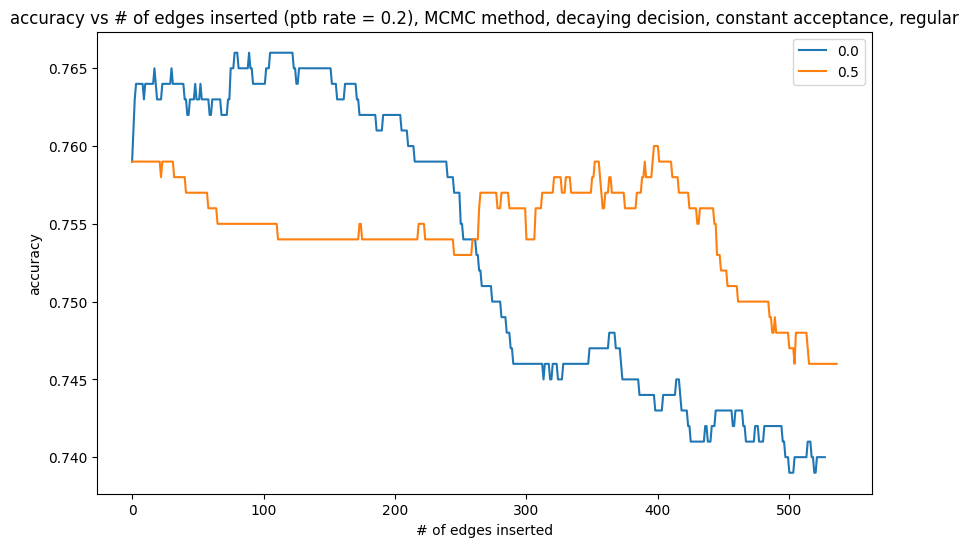

In [44]:
plot_results(split_dic_decreasing_constant_acc, ptb_rate, "MCMC", "decaying", "constant", "accuracy", "regular")

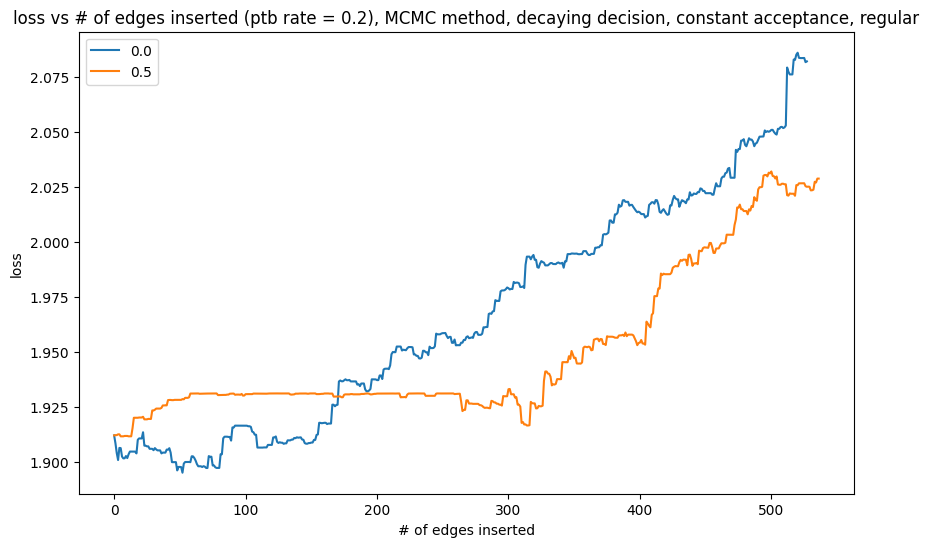

In [45]:
plot_results(split_dic_decreasing_constant_loss, ptb_rate, "MCMC", "decaying", "constant", "loss", "regular")

In [46]:
split_dic_decreasing_gradual_acc = defaultdict(defaultdict(list))
split_dic_decreasing_gradual_loss = defaultdict(defaultdict(list))
itrs_four = defaultdict(defaultdict(int))

In [47]:
for s in splits:
    for j in range(trials):
        if s == 0.0:
            split_dic_decreasing_gradual_acc[s][j], split_dic_decreasing_gradual_loss[s][j], itrs_four[s][j] = full_metattack_acc[j], full_metattack_loss[j], full_metattack_itrs[j]
        else:
            split_dic_decreasing_gradual_acc[s][j], split_dic_decreasing_gradual_loss[s][j], itrs_four[s][j] = two_phase_attack_mcmc(data, train, model, s, edges_to_add, decreasing_fn, increasing_fn, device, is_reversed=False, verbose=True)

Peturbing graph...:   0%|          | 0/263 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
max_change: 0.0191191828250885, master_clean_delta: -0.002245306968688965, master_dirty_delta: -0.002245306968688965
Attempt: 1, Selected: 0
max_change: 0.0191191828250885, master_clean_delta: 0.004853487014770508, master_dirty_delta: -0.0006378889083862305
Attempt: 2, Selected: 0
max_change: 0.0191191828250885, master_clean_delta: 0.0, master_dirty_delta: 0.0
Attempt: 24, Selected: 10
max_change: 0.0191191828250885, master_clean_delta: -0.0003336668014526367, master_dirty_delta: 0.0006213188171386719
Attempt: 25, Selected: 10
max_change: 0.0191191828250885, master_clean_delta: -0.004074573516845703, master_dirty_delta: -0.0018857717514038086
Attempt: 26, Selected: 10
max_change: 0.0191191828250885, master_clean_delta: -0.0011371374130249023, master_dirty_delta: 0.0003135204315185547
Attempt: 27, Selected: 10
max_change: 0.0191191828250885, master_clean_delta: -0.004663586616516113, master_dirty_delta: -0.0024743080139160156
Attempt: 28, Selected: 10
max_change:

Peturbing graph...:   0%|          | 0/272 [00:00<?, ?it/s]

In [48]:
record1 = Recording(split_dic_decreasing_gradual_loss, split_dic_decreasing_gradual_acc, itrs_four, Model.GCN, Dataset.CORA, AcceptFn.CONSTANT, SelectFn.DECAYING, Reverse.ATTACKED)
record1.save(f'data_collection/{"mcmc"}_{"gcn"}_{"cora"}_{"increasing"}_{"decaying"}_{"attacked"}_results.pkl')

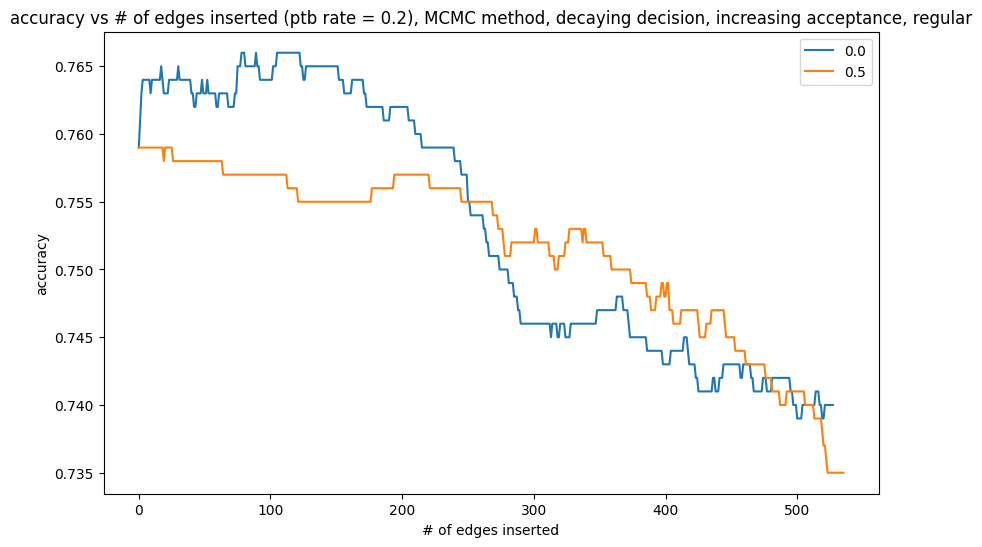

In [49]:
plot_results(split_dic_decreasing_gradual_acc, ptb_rate, "MCMC", "decaying", "increasing", "accuracy", "regular")

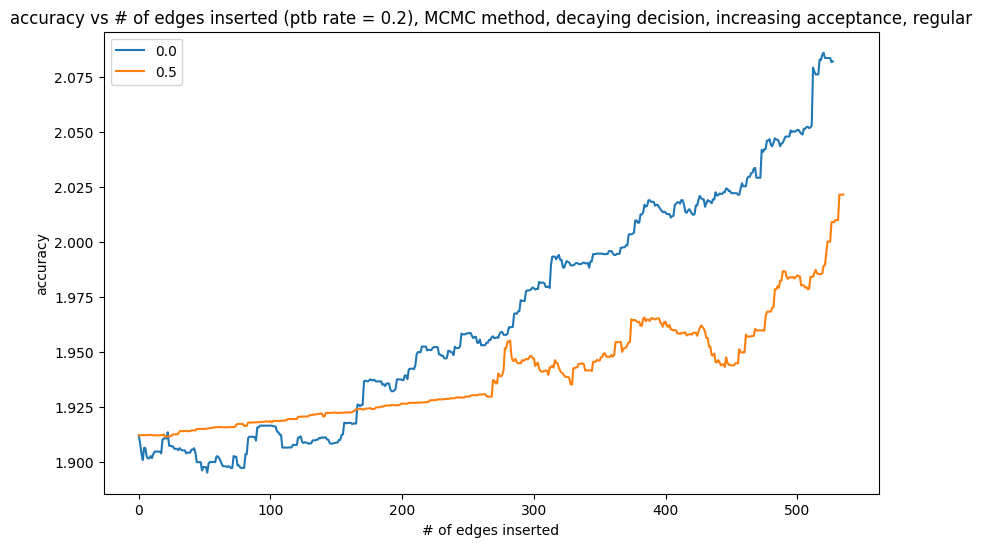

In [50]:
plot_results(split_dic_decreasing_gradual_loss, ptb_rate, "MCMC", "decaying", "increasing", "accuracy", "regular")